In [2]:
!pip install -q sentence-transformers hdbscan umap-learn unidecode


In [3]:
import pandas as pd


products = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/products.csv")
aisles = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/aisles.csv")
departments = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/departments.csv")

In [4]:
# Merge metadata
prod = products.merge(aisles, on="aisle_id").merge(departments, on="department_id")
prod = prod[["product_id","product_name","aisle","department"]]
prod.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry


In [5]:
import re
from unidecode import unidecode

# Patterns for sizes, units, and noise words
UNITS = r"(oz|ounce|ounces|lb|pound|g|kg|ml|l|liter|litre|pack|ct|count)"
SIZES = rf"\b\d+(\.\d+)?\s*({UNITS})\b|\b(pack\s*of\s*\d+)\b|\b\d+\b"
NOISE = r"\b(organic|gluten[- ]?free|non[- ]?gmo|fresh|new|brand|original)\b"
PUNCT = r"[^\w\s]"

def clean_name(s: str) -> str:
    s = unidecode(str(s)).lower().strip()
    s = re.sub(SIZES, " ", s)
    s = re.sub(PUNCT, " ", s)
    s = re.sub(NOISE, " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

prod["name_clean"] = prod["product_name"].apply(clean_name)
prod.sample(10)[["product_name","name_clean","aisle","department"]]


,product_name,name_clean,aisle,department
31898,Original Hard Candy,hard candy,candy chocolate,snacks
25372,NOTICEables Dual Scented Oil Refill + Free War...,noticeables dual scented oil refill free warme...,air fresheners candles,household
35565,Stoneground Cinnamon Cluster Cereal Flakes,stoneground cinnamon cluster cereal flakes,cereal,breakfast
5964,Barolo Salami,barolo salami,packaged meat,meat seafood
43618,Mango Protein Juice Smoothie,mango protein juice smoothie,refrigerated,beverages
23372,Chocolate Peanut Crisp Protein Bar,chocolate peanut crisp protein bar,energy granola bars,snacks
6640,Premium Spun Honey,premium spun honey,honeys syrups nectars,pantry
37614,Veggie Pick Ups Diced Carrots,veggie pick ups diced carrots,baby food formula,babies
42121,"Frozen Desserts, Fit, Cappuccino",frozen desserts fit cappuccino,ice cream ice,frozen
36247,Mint Chocolate Chunk Protein Bar,mint chocolate chunk protein bar,energy granola bars,snacks


In [6]:
# Frequency count
freq = prod["name_clean"].value_counts().rename("freq").reset_index()
freq = freq.rename(columns={"index":"name_clean"})

# Merge back to get sample product_id and original name
canon = freq.merge(prod, on="name_clean", how="left").drop_duplicates("name_clean")
canon = canon[["name_clean","product_id","product_name","freq","aisle","department"]]
canon.head()


,name_clean,product_id,product_name,freq,aisle,department
0,reduced fat milk,1940,Organic 2% Reduced Fat Milk,11,milk,dairy eggs
11,apple juice,14957,Organic 100% Apple Juice,9,juice nectars,beverages
20,lowfat milk,6533,1% Lowfat Organic Milk,8,milk,dairy eggs
28,vitamin d3 iu,4388,Vitamin D3 2000 IU,7,vitamins supplements,personal care
35,dark chocolate bar,3083,85% Dark Chocolate Bar,7,candy chocolate,snacks


In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")  # fast and effective
names = canon["name_clean"].tolist()
X = model.encode(names, batch_size=256, convert_to_numpy=True, normalize_embeddings=True)


2025-08-29 09:42:32.717255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756460552.927089      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756460552.987269      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/184 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


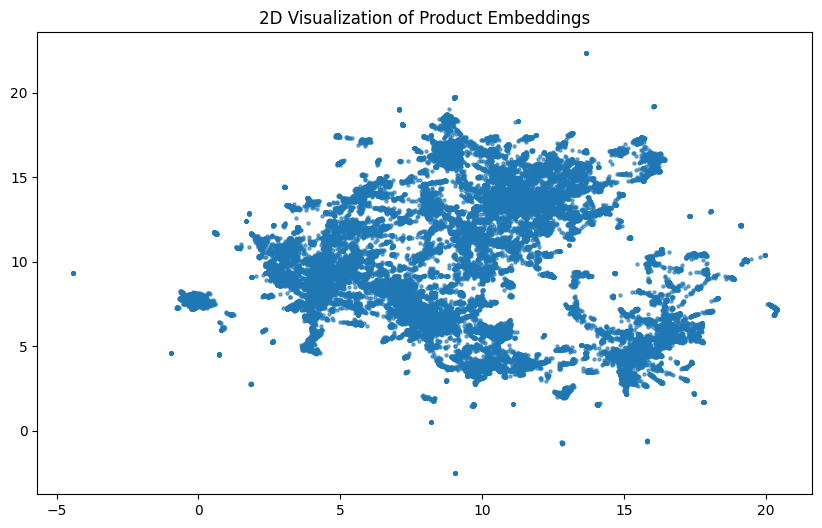

In [8]:
import umap
import matplotlib.pyplot as plt

X2 = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42).fit_transform(X)
plt.figure(figsize=(10,6))
plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.6)
plt.title("2D Visualization of Product Embeddings")
plt.show()


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X)


In [10]:
import hdbscan

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10, metric="euclidean")
labels = clusterer.fit_predict(X_reduced)
canon["cluster_hdb"] = labels
canon["cluster_hdb"].value_counts().head(10)


cluster_hdb
-1      38299
 119      585
 43       408
 56       315
 39       274
 123      251
 85       218
 58       191
 95       179
 36       170
Name: count, dtype: int64

In [11]:
from sklearn.metrics import silhouette_score

# Silhouette score (exclude noise points labeled -1)
mask = canon["cluster_hdb"] != -1
sil = silhouette_score(X_reduced[mask], canon.loc[mask,"cluster_hdb"]) if mask.any() else float("nan")
print("Silhouette score:", sil)

# Purity vs aisle
def purity(df, cluster_col, meta_col):
    groups = df[df[cluster_col] != -1].groupby(cluster_col)[meta_col].apply(lambda s: s.value_counts().max()/len(s))
    return groups.mean()

purity_aisle = purity(canon, "cluster_hdb", "aisle")
purity_dept = purity(canon, "cluster_hdb", "department")
print("Purity - Aisle:", purity_aisle)
print("Purity - Department:", purity_dept)


Silhouette score: 0.245464
Purity - Aisle: 0.7599214061909134
Purity - Department: 0.8368215224026049


In [12]:
def exemplars(df, label_col, n=10):
    ex = []
    for cid, g in df[df[label_col]!=-1].groupby(label_col):
        top = g.sort_values("freq", ascending=False).head(n)
        ex.append((cid, top["name_clean"].tolist()))
    return ex

examples = exemplars(canon, "cluster_hdb", n=8)
for cid, items in examples[:15]:
    print(f"\nCluster {cid}:")
    for it in items: print(" -", it)



Cluster 0:
 - soft white w light bulb
 - general purpose light bulbs soft white 25w
 - clear watt appliance light bulb
 - light bulb soft white 150w
 - soft white watts general purpose light bulb
 - indoor floodlight soft white 65w light bulb
 - watt reveal way light bulb
 - soft white watts way light bulbs

Cluster 1:
 - imitation crab leg style
 - crab cakes handmade
 - crab delights imitation flake style crab meat
 - crab meat backfin lump
 - premium crab meat
 - imitation crab sticks
 - flake style imitation crab
 - imitation crabmeat

Cluster 2:
 - large grade aa eggs
 - grade a large brown eggs
 - egg whites
 - grade a large eggs
 - egg nog
 - brown eggs
 - liquid egg whites
 - extra large eggs

Cluster 3:
 - living drip catch cuff large gloves
 - large green gloves
 - handsaver flex strong small gloves
 - latex gloves
 - medium household gloves
 - medium latex gloves
 - bliss premium latex free gloves
 - medium premium latex free gloves

Cluster 4:
 - premium lubricant condoms 

In [13]:
canon["cluster_hdb"] = labels


In [14]:
# Group by cluster
cluster_groups = canon.groupby("cluster_hdb")

# Display first 5 clusters with product names and aisles
for cluster_id, group in cluster_groups:
    if cluster_id == -1:  # Skip noise points
        continue
    print(f"\nCluster {cluster_id} (size={len(group)}):")
    for _, row in group.iterrows():
        print(f" - {row['name_clean']} ({row['aisle']})")
    # Stop after first 5 clusters
    if cluster_id >= 4:
        break



Cluster 0 (size=32):
 - soft white w light bulb (more household)
 - general purpose light bulbs soft white 25w (more household)
 - light bulbs soft white 40w (more household)
 - halogen soft white watt light bulbs (more household)
 - light bulb a21 way (more household)
 - watt energy smart soft white light bulb (more household)
 - soft white light bulbs w (more household)
 - bulb crystal clear medium base watt (more household)
 - soft white watts halogen bulb (more household)
 - soft white halogen watt double life light bulb (more household)
 - w indoor light bulbs (more household)
 - reading way indoor watts light bulb (more household)
 - soft white watts halogen bulbs (more household)
 - nightlight specialty watt light bulbs (more household)
 - reveal watt halogen bulb (more household)
 - crystal clear decorative watt a medium base ceiling fan light bulb (other)
 - energy efficient soft white watt general purpose halogen bulbs (more household)
 - watt decorative soft white light bul

In [15]:
def cluster_purity(df, cluster_col="cluster_hdb", aisle_col="aisle"):
    purities = []
    for cluster_id, group in df[df[cluster_col]!=-1].groupby(cluster_col):
        top_count = group[aisle_col].value_counts().max()
        purities.append(top_count / len(group))
    return sum(purities)/len(purities)

purity_score = cluster_purity(canon)
print("Average cluster purity (aisle):", purity_score)


Average cluster purity (aisle): 0.7599214061909135
